INFO       Cache size for target "cython": 2242 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\Joseph Hwang\.cython\brian_extensions" directory. [brian2]


Starting simulation at t=1. s for a duration of 9. s
1.3689 s (15%) simulated in 10s, estimated 56s remaining.
3.2113 s (35%) simulated in 20s, estimated 36s remaining.
5.0161 s (55%) simulated in 30s, estimated 24s remaining.
6.8585 s (76%) simulated in 40s, estimated 13s remaining.
8.6855 s (96%) simulated in 50s, estimated 2s remaining.
9. s (100%) simulated in 51s


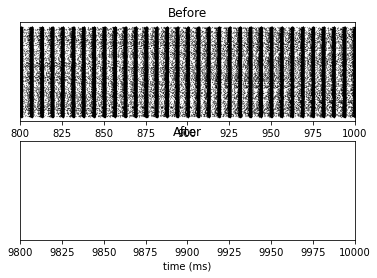

In [1]:
from brian2 import *

# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells

tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections

tau_stdp = 20*ms    # STDP time constant

simtime = 10*second # Simulation time

# ###########################################
# Neuron model for Input Layer
# ###########################################
gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current

eqs_neurons_input='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''

# ###########################################
# Initialize neuron group for Input Layer
# ###########################################
input_neurons = NeuronGroup(784, model=eqs_neurons_input, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')

# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance

eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er)))/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''

# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
Pe = neurons[:NE]
Pi = neurons[NE:]

# ###########################################
# Connecting the network
# ###########################################

con_e = Synapses(Pe, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(p=epsilon)
con_ii = Synapses(Pi, Pi, on_pre='g_gaba += 3*nS')
con_ii.connect(p=epsilon)

# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''
alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight

feedforward_input = Synapses(input_neurons, neurons, model=eqs_stdp_inhib,
                  on_pre='''Apre += 1.
                         w = clip(w+(Apost-alpha)*eta, 0, gmax)
                         g_gaba += w*nS''',
                  on_post='''Apost += 1.
                          w = clip(w+Apre*eta, 0, gmax)
                     ''')
feedforward_input.connect()
feedforward_input.w = 1e-10

#feedforward_input = Synapses(input_neurons, neurons)
#feedforward_input.connect()

con_ie = Synapses(Pi, Pe, model=eqs_stdp_inhib,
                  on_pre='''Apre += 1.
                         w = clip(w+(Apost-alpha)*eta, 0, gmax)
                         g_gaba += w*nS''',
                  on_post='''Apost += 1.
                          w = clip(w+Apre*eta, 0, gmax)
                       ''')
con_ie.connect(p=epsilon)
con_ie.w = 1e-10

# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(Pe) #
sm_1 = SpikeMonitor(input_neurons) #
sm_2 = SpikeMonitor(Pi) #
sm_3 = SpikeMonitor(neurons) #
sm_4 = StateMonitor(feedforward_input, ['w', 'v'], record=[0]) #
sm_5 = StateMonitor(con_ie, ['w', 'v'], record=[0,1,2]) #

# ###########################################
# Run without plasticity
# ###########################################
eta = 0          # Learning rate
run(1*second)

# ###########################################
# Run with plasticity
# ###########################################
eta = 1e-2          # Learning rate
run(simtime-1*second, report='text')

# ###########################################
# Make plots
# ###########################################

i, t = sm.it
subplot(211)
plot(t/ms, i, 'k.', ms=0.25)
title("Before")
xlabel("")
yticks([])
xlim(0.8*1e3, 1*1e3)
subplot(212)
plot(t/ms, i, 'k.', ms=0.25)
xlabel("time (ms)")
yticks([])
title("After")
xlim((simtime-0.2*second)/ms, simtime/ms)
show()

In [2]:
#2D array with shape(num_times, num_indices)
sm_5.w.T

array([[1.00000000e-10, 1.00000000e-10, 1.00000000e-10],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10],
       ...,
       [1.00258227e-10, 1.00149105e-10, 1.00259521e-10],
       [1.00258227e-10, 1.00149105e-10, 1.00259521e-10],
       [1.00258227e-10, 1.00149105e-10, 1.00259521e-10]])

In [3]:
#2D array with shape (num_indices, num_times)
sm_5.w

array([[1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
        1.00258227e-10, 1.00258227e-10, 1.00258227e-10],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
        1.00149105e-10, 1.00149105e-10, 1.00149105e-10],
       [1.00000000e-10, 1.00000000e-10, 1.00000000e-10, ...,
        1.00259521e-10, 1.00259521e-10, 1.00259521e-10]])

In [4]:
len(sm_5.w[0])

100000

Text(0, 0.5, 'Neuron index')

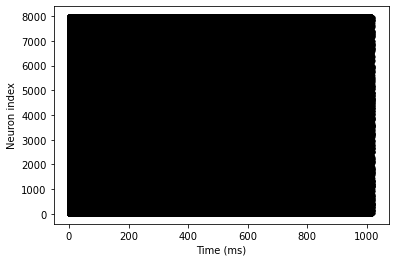

In [5]:
plot(sm.t/ms, sm.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')

Text(0, 0.5, 'Neuron index')

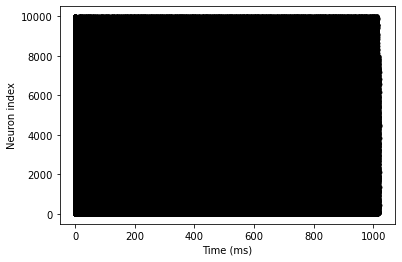

In [6]:
plot(sm_3.t/ms, sm_3.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')

Text(0, 0.5, 'Neuron index')

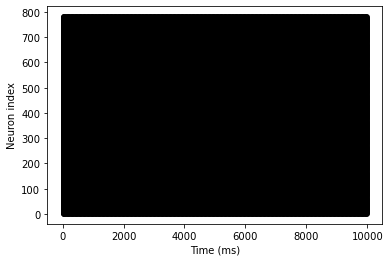

In [7]:
plot(sm_1.t/ms, sm_1.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')

Text(0.5, 0, 'Synapse index')

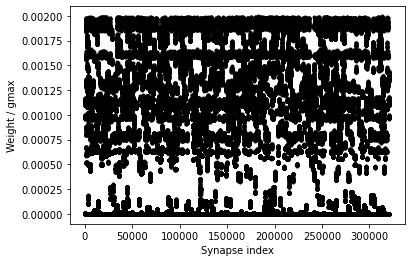

In [8]:
plot(con_ie.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')

Text(0.5, 0, 'Synapse index')

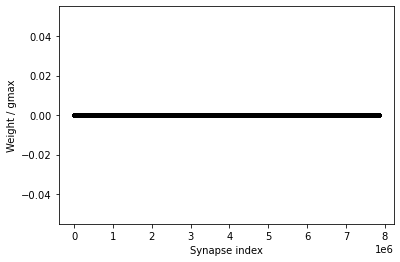

In [9]:
plot(feedforward_input.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')

Text(0, 0.5, 'Neuron index')

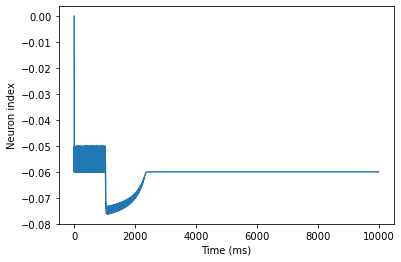

In [10]:
plot(sm_4.t/ms, sm_4.v.T)
xlabel('Time (ms)')
ylabel('Neuron index')

Text(0, 0.5, 'Neuron Weight')

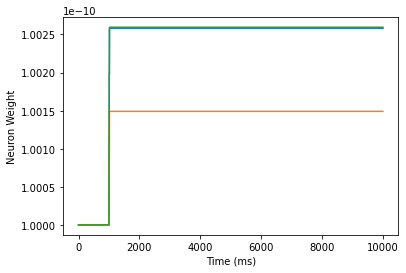

In [11]:
plot(sm_5.t/ms, sm_5.w.T)
xlabel('Time (ms)')
ylabel('Neuron Weight')

Text(0.5, 0, 'Weight / gmax')

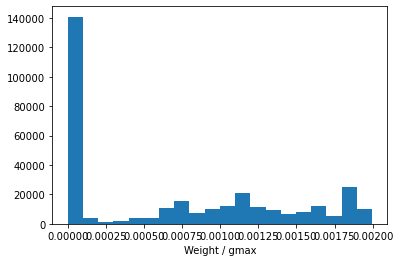

In [12]:
hist(con_ie.w / gmax, 20)
xlabel('Weight / gmax')

In [13]:
#hist(feedforward_input.w / gmax, 20)
#xlabel('Weight / gmax')

In [14]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [15]:
#visualise_connectivity(con_e)

In [16]:
#visualise_connectivity(con_ie)

In [17]:
#visualise_connectivity(con_ii)

In [18]:
#visualise_connectivity(feedforward_input)